## 0. Import statements

In [1]:
import sbmlnetwork
import libsbml

import pandas as pd
import tellurium as te
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re

In [2]:
rxns = pd.read_csv('src/frenda_brenda/Files/KEGG_Filtered/Reactions_M0.csv')

## 1. Retrieve coordinates from KEGG
### 1a. Get the (x,y) coordinates for each species in the KEGG map

In [3]:
def get_kegg_orthology_ids(reaction_ids):
    orthology_dict = {}
    for reaction_id in reaction_ids:
        url = f"https://www.kegg.jp/dbget-bin/www_bget?rn:{reaction_id}"
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find the orthology section
        orthology_section = soup.find('th', string="Orthology")
        if orthology_section:
            # Get the orthology ID from the adjacent <td> tag
            orthology_ids = orthology_section.find_next('td').find_all('a')
            # Filter IDs that start with 'K'
            orthology_dict[reaction_id] = [ortho_id.get_text() for ortho_id in orthology_ids if ortho_id.get_text().startswith('K')]
        else:
            orthology_dict[reaction_id] = []
    
    return orthology_dict

In [4]:
orthology_ids = get_kegg_orthology_ids(rxns['Reaction ID'])

In [5]:
import xml.etree.ElementTree as ET
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas

def map_reaction_to_entry_id(xml_file_path, reaction_orthology_dict):
    # Parse the XML file
    pathway = KGML_parser.read(open(xml_file_path, 'r'))

    # Initialize dictionary to hold the reaction ID -> entry ID mapping
    reaction_entry_map = {}

    # Loop through each entry in the pathway
    for entry in pathway.entries.values():
        # Check if the entry is of type 'ortholog'
        if entry.type == "ortholog":
            # Extract the orthology IDs (split by space, remove 'ko:' prefix)
            orthology_ids_in_entry = entry.name.replace('ko:', '').split()

            # Convert to set for comparison
            orthology_ids_in_entry_set = set(orthology_ids_in_entry)

            # Loop through the reaction dictionary
            for reaction_id, orthology_ids in reaction_orthology_dict.items():
                if len(orthology_ids)==0:
                    continue
                # Convert orthology_ids from the reaction dictionary to a set
                orthology_ids_set = set(orthology_ids)

                # Check if all orthology IDs in the entry are present in orthology_ids_set
                # CHANGING THIS AS AN EXPERIMENT: CHECK IF ANY OF THE ORTHOLOGY IDS IN THE ENTRY ARE PRESENT IN ORTHOLOGY_IDS_SET
                # if not orthology_ids_set.isdisjoint(orthology_ids_in_entry_set):
                # if orthology_ids_set.issubset(orthology_ids_in_entry_set):
                if not orthology_ids_set.isdisjoint(orthology_ids_in_entry_set):
                    # Add the mapping to the dictionary
                    if reaction_id not in reaction_entry_map:
                        reaction_entry_map[reaction_id] = []
                    reaction_entry_map[reaction_id].append(entry.id)  # Save the entry ID

    return reaction_entry_map

In [6]:
xml_file = 'ko01100.xml'
reaction_entry_map = map_reaction_to_entry_id(xml_file, orthology_ids)

In [7]:
pathway = KGML_parser.read(open(xml_file, 'r'))
reaction_dict = reaction_entry_map
    
# Initialize dictionary to hold the cpd ID and Reaction ID mapping
cpd_coordinates_map = {}

# Loop through the reaction dictionary
for reaction_id, entry_ids in reaction_dict.items():
    for entry_id in entry_ids:
        # Search for the reaction in the pathway
        reaction_entry = next((reaction for reaction in pathway.reactions if reaction.id == entry_id), None)

        if reaction_entry:
            newrns = []
            for rn in reaction_entry._names:
                newrns.append(rn.replace('rn:',''))
            if reaction_id in newrns:
                # Collect substrates
                sloop_counter = 0
                for substrate in reaction_entry._substrates:
                    substrate_entry = next((sub for sub in pathway.entries.values() if sub.id == substrate), None)
                    x, y = substrate_entry.graphics[0].x, substrate_entry.graphics[0].y
                    
                    rxnentry = str(reaction_entry)
                    # Split the string into lines and find the line containing 'Substrates'
                    substrates_line = next(line for line in rxnentry.splitlines() if 'Substrates:' in line)
                    # Extract the part of the line after 'Substrates:'
                    substrates_part = substrates_line.split('Substrates: ')[1]
                    # Split the substrates by comma and strip the 'cpd:' prefix
                    cpd_id = [substrate.strip().replace('cpd:', '') for substrate in substrates_part.split(',')][sloop_counter]
                    sloop_counter += 1

                    cpd_coordinates_map[f"{cpd_id}_{reaction_id}_{entry_id}"] = (x, y)

                # Collect products
                ploop_counter = 0
                for product in reaction_entry._products:
                    product_entry = next((prod for prod in pathway.entries.values() if prod.id == product), None)
                    x, y = product_entry.graphics[0].x, product_entry.graphics[0].y
                    
                    rxnentry = str(reaction_entry)
                    # Split the string into lines and find the line containing 'Substrates'
                    products_line = next(line for line in rxnentry.splitlines() if 'Products:' in line)
                    # Extract the part of the line after 'Substrates:'
                    products_part = products_line.split('Products: ')[1]
                    # Split the substrates by comma and strip the 'cpd:' prefix
                    cpd_id = [product.strip().replace('cpd:', '') for product in products_part.split(',')][ploop_counter]
                    ploop_counter += 1

                    cpd_coordinates_map[f"{cpd_id}_{reaction_id}_{entry_id}"] = (x, y)

In [8]:
data = pd.read_csv('/workspaces/ECFERS/kegg_labels_add.csv',dtype='str',encoding='us-ascii',encoding_errors='ignore')
data = data.where(data.notnull(), None)

In [9]:
# Create a new dictionary with replaced keys
cpd_coordinates_map_tran = {}
for key, value in cpd_coordinates_map.items():
    new_key = key
    # Check for each "KEGG ID" in the key string
    for _, row in data.iterrows():
        kegg_id = row['KEGG ID']
        id_value = row['ID']
        # Replace any occurrence of the "KEGG ID" within the key string
        if kegg_id in new_key:
            new_key = new_key.replace(kegg_id, id_value)
    # Add the modified key-value pair to the new dictionary
    cpd_coordinates_map_tran[new_key] = value

## 2. Apply KEGG coordinates to SBMLNetwork layout
## You can ignore all of this and just run the final cell to load the SBML model

### 2a. Translate the antimony file with KEGG compound IDs to have human readable names. Then, build an SBML file from this translated antimony file. Use libSBML to add in display names and annotations.

Read in the KEGG translation file. Only run the first code block if you need to regenerate the translation file with code complacent IDs.

In [10]:
data = pd.read_csv('/workspaces/ECFERS/kegg_labels.csv',dtype='str',encoding='us-ascii',encoding_errors='ignore')
data = data.where(data.notnull(), None)

def clean_string(s):
    # Remove unwanted characters
    cleaned = re.sub(r"[-,+,\'\[\]\(\)\s]", "", s)
    # If the string starts with a digit, add an underscore at the beginning
    if cleaned[0].isdigit():
        cleaned = f"_{cleaned}"
    return cleaned

# Apply the function to the second column and create a new column with the result
data['ID'] = data.iloc[:, 1].apply(clean_string)

data.to_csv('/workspaces/ECFERS/kegg_labels_add.csv')

In [11]:
data = pd.read_csv('/workspaces/ECFERS/kegg_labels_add.csv',dtype='str',encoding='us-ascii',encoding_errors='ignore')
data = data.where(data.notnull(), None)

In [12]:
# Load the text file. Change this string to reflect whichever antimony file you want to translate.
with open('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0.txt', 'r') as file:
    text = file.read()

# Replace each "KEGG ID" in the text with the corresponding "ID"
for _, row in data.iterrows():
    kegg_id = row['KEGG ID']
    id_value = row['ID']
    text = text.replace(str(kegg_id), str(id_value))

# Save the modified text to a new file. Update this string to reflect your naming convention.
with open('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.txt', 'w') as file:
    file.write(text)

We now have a translated antimony file and SBML file. We need to use the KEGG labels Rosetta stone to add in the display names and annotations to the SBML file.

In [13]:
# Read the existing file
with open('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.txt', 'r') as file:
    content = file.readlines()

# Append lines to the file based on data in your DataFrame, only if id_value exists in content
with open('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.txt', 'a') as file:
    file.write(f'\n')  # Add a newline before appending new content
    for _, row in data.iterrows():
        kegg_id = row['KEGG ID']
        label = row['Label']
        id_value = row['ID']

        # Check if id_value appears in the existing content
        if any(id_value in line for line in content):
            # Write each new line to the file
            file.write(f'{id_value} is "{label}";\n')
            file.write(f'{id_value} identity "http://identifiers.org/kegg.compound/{kegg_id}";\n')

In [14]:
with open('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.txt', 'r') as f:
    antimony = f.read()

# Save the modified text to a new SBML file. Update this string to reflect your naming convention.
r  = te.loada(antimony)
r.exportToSBML('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.sbml', current=False)

### 2b. Remove enzymes, inhibitors, and cofactors from the visual.

In [15]:
#remove any unused species
def remove_unused_species(sbml_file, output_file):
    # Read SBML file
    reader = libsbml.SBMLReader()
    document = reader.readSBML(sbml_file)
    model = document.getModel()
    
    if model is None:
        print("Failed to read model from SBML file.")
        return

    # Collect IDs of all species involved in reactions
    used_species = set()
    for reaction in model.getListOfReactions():
        for reactant in reaction.getListOfReactants():
            used_species.add(reactant.getSpecies())
        for product in reaction.getListOfProducts():
            used_species.add(product.getSpecies())
        for modifier in reaction.getListOfModifiers():
            used_species.add(modifier.getSpecies())
    
    # Collect IDs of all species in the model
    all_species = {species.getId() for species in model.getListOfSpecies()}
    
    # Determine unused species
    unused_species = all_species - used_species
    
    # Remove unused species
    for species_id in unused_species:
        species = model.getSpecies(species_id)
        model.removeSpecies(species_id)

    # Write the updated model to a new SBML file
    writer = libsbml.SBMLWriter()
    writer.writeSBMLToFile(document, output_file)
    print(f"Updated SBML file saved to {output_file}")

In [16]:
M0_original = '/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed.sbml'
M0_modified = '/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_noextras.sbml'
remove_unused_species(M0_original, M0_modified)

Updated SBML file saved to /workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_noextras.sbml


In [17]:
#remove enzymes
def remove_ecs(input_filename, output_filename):
    # Load SBML document
    document = libsbml.readSBML(input_filename)
    if document.getNumErrors() > 0:
        raise Exception('Error reading SBML file.')
    
    # Get model from document
    model = document.getModel()
    if model is None:
        raise Exception('No model found in the SBML document.')
    
    # Loop through reactions
    for i in range(model.getNumReactions()):
        reaction = model.getReaction(i)
        reactants = set(reaction.getReactant(j).getSpecies() for j in range(reaction.getNumReactants()))
        products = set(reaction.getProduct(j).getSpecies() for j in range(reaction.getNumProducts()))
        
        mutual_species = reactants & products
        
        for species in mutual_species:
            for j in range(reaction.getNumReactants()):
                if reaction.getReactant(j).getSpecies() == species:
                    reaction.removeReactant(j)
                    break  # Break after removing to avoid index issues

            for j in range(reaction.getNumProducts()):
                if reaction.getProduct(j).getSpecies() == species:
                    reaction.removeProduct(j)
                    break  # Break after removing to avoid index issues

    # Save the modified SBML document
    success = libsbml.writeSBMLToFile(document, output_filename)
    print(f"Updated SBML file saved to {output_filename}")
    if not success:
        raise Exception('Error writing SBML file.')

In [18]:
reader = libsbml.SBMLReader()
document = reader.readSBML('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_ECfilt.sbml')
model = document.getModel()

In [19]:
def remove_ECs_2(file_in, file_out):
    # Read the SBML file
    reader = libsbml.SBMLReader()
    document = reader.readSBML(file_in)
    model = document.getModel()
    
    if model is None:
        raise ValueError("Could not find a valid model in the SBML file.")
    
    # Collect the species to remove
    species_to_remove = []
    for species in model.getListOfSpecies():
        if species.id.startswith(("e", "h")):
            species_to_remove.append(species.id)

    # Remove the collected species
    for species in species_to_remove:
        model.removeSpecies(species)

    # Write the modified SBML to a new file
    writer = libsbml.SBMLWriter()
    writer.writeSBMLToFile(document, file_out)
    
    print(f"Modified SBML saved to {file_out}")

In [20]:
M0_wECs = '/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_noextras.sbml'
M0_woutECS = '/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_ECfilt.sbml'
remove_ecs(M0_wECs, M0_woutECS)
remove_ECs_2(M0_woutECS, '/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_fin.sbml')

Updated SBML file saved to /workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_ECfilt.sbml
Modified SBML saved to /workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_fin.sbml


In [21]:
#Change this path to get new model
M0 = sbmlnetwork.load('/workspaces/ECFERS/src/frenda_brenda/Files/KEGG_Filtered/M0_renamed_fin.sbml')

### 2b. Match reaction labels (our convention) with reaction IDs (KEGG convention)

In [22]:
M0_reaction_labels = M0.getListOfReactionIds()

df = pd.read_csv('src/frenda_brenda/Files/KEGG_Filtered/Reactions_M0.csv')
label_to_reaction_id = dict(zip(df['Label'], df['Reaction ID']))
M0_reactionIDs = [label_to_reaction_id.get(item, item) for item in M0_reaction_labels]

print(f'List of reaction labels: {M0_reaction_labels}')
print()
print(f'List of corresponding reaction IDs: {M0_reactionIDs}')

label_to_ID_dict = {}
i = 0
for label in M0_reaction_labels:
    label_to_ID_dict[label] = M0_reactionIDs[i]
    i = i+1

print()
print(label_to_ID_dict)

List of reaction labels: ['R406', 'R197', 'R269', 'R345']

List of corresponding reaction IDs: ['R00220', 'R00519', 'R00342', 'R00344']

{'R406': 'R00220', 'R197': 'R00519', 'R269': 'R00342', 'R345': 'R00344'}


In [23]:
def getSpecsinRxn(reaction):
    #get the number of species involved in the reaction
    numSpecs = M0.getNumSpeciesReferences(reaction, reaction_glyph_index=0, layout_index=0)
    specList = []
    for i in range(numSpecs):
        #get the ID of each species
        specID = M0.getSpeciesReferenceSpeciesId(reaction, reaction_glyph_index=0, species_reference_index=i, layout_index=0)
        specList.append(specID)
    return specList

In [24]:
specs_in_rxns = {}
for label in M0_reaction_labels:
    specs_in_rxns[label] = getSpecsinRxn(label)

print(specs_in_rxns)

{'R406': ['Serine', 'NH3', 'Pyr'], 'R197': ['NAD', 'Formate', 'NADH', 'CO2', 'H'], 'R269': ['NAD', 'Mal', 'NADH', 'Oxa', 'H'], 'R345': ['ATP', 'Pyr', 'CO2', 'ADP', 'PO4', 'Oxa']}


### 2c. Set the coordinates in SBMLNetwork.

Save those coordinates in a list to fix autolayout locked_nodes parameter.

### Apply a unique alias ID to every species

In [25]:
# M1.autolayout(max_num_connected_edges=1)
# set_nodes = []
# speciesToHide = []
# for rxn_label, specs in specs_in_rxns.items():
#     corresponding_ID = label_to_ID_dict[rxn_label]
#     for spec in specs:
#         spec_react = spec + '_' + corresponding_ID

#         matching_keys = [key for key in cpd_coordinates_map_tran if key.startswith(spec_react)]

#         if matching_keys:
#             for key_index, key in enumerate(matching_keys):
#                 if key_index > M1.getNumReactionGlyphs(rxn_label) - 1:
#                     M1.createAliasReactionGlyph(rxn_label)
#                 rxn_glyph_index = M1.getNumReactionGlyphs(rxn_label) - 1
#                 specesglyphindex = M1.getSpeciesGlyphIndex(spec,rxn_label,reaction_glyph_index=rxn_glyph_index)
            
#                 coords = cpd_coordinates_map_tran[key]
#                 set_nodes.append(spec)
#                 M1.setX(spec, coords[0], graphical_object_index=specesglyphindex) # additional parameter, update_curves = False. will make this faster
#                 M1.setY(spec, coords[1], graphical_object_index=specesglyphindex) # additional parameter, update_curves = False. will make this faster
#                 print(f'{spec_react} in {rxn_label}/{corresponding_ID} has species glyph index of {specesglyphindex} and coordinates of {coords} from KEGG')
#         else:
#             print(f'{spec_react} in {rxn_label}/{corresponding_ID} has species glyph index of {specesglyphindex} and no available coordinates from KEGG')
#             speciesToHide.append([spec, rxn_label])

In [26]:
#get the graphical_object_index for species w/ alias nodes
def aliasIndexExtract(speciesID, reactionID, model):
    for i in range(model.getNumSpeciesReferences(reactionID)):
        specglyphID = model.getSpeciesReferenceSpeciesGlyphId(reactionID, species_reference_index=i)
        for j in range(model.getNumSpeciesGlyphs(speciesID)):
            objID = model.getNthSpeciesGlyphId(speciesID, j)
            if objID == specglyphID:
                return j
    return -1

In [27]:
cpd_coordinates_map_tran

{'Pyr_R00220_4482': (2399.0, 1713.0),
 'Serine_R00220_4482': (2965.0, 1713.0),
 'Mal_R00342_4357': (2216.0, 2075.0),
 'Oxa_R00342_4357': (2321.0, 1979.0),
 'Mal_R00342_5622': (2171.0, 3134.0),
 'Oxa_R00342_5622': (2234.0, 3105.0),
 'Formate_R00519_2418': (2132.0, 2959.0),
 'CO2_R00519_2418': (2234.0, 2959.0),
 'H_R00519_2418': (2162.0, 2884.0),
 'Oxa_R00344_3008': (2321.0, 1979.0),
 'Pyr_R00344_3008': (2399.0, 1713.0)}

In [28]:
M0.autolayout(max_num_connected_edges=1)
set_nodes = []
all_nodes = []
rxn_entry_glyph = []

for rxn_label, specs in specs_in_rxns.items():
    corresponding_ID = label_to_ID_dict[rxn_label]
    for spec in specs:
        spec_react = spec + '_' + corresponding_ID
        matching_keys = [key for key in cpd_coordinates_map_tran if key.startswith(spec_react)]
        all_nodes.append([spec, rxn_label,0])
        
        if matching_keys:
            # Process each matching key, create aliases if multiple coordinates exist
            for key_index, key in enumerate(matching_keys):
                entry = key.split('_')[-1]
                if (key_index > 0) and (entry not in rxn_entry_glyph):  # For each additional match beyond the first, create an alias
                    M0.createAliasReactionGlyph(rxn_label)
                    rxn_entry_glyph.append(entry)
                    [all_nodes.append([s, rxn_label, key_index]) for s in specs]

                # Get the reaction glyph index, ensuring we have the most recent one
                rxn_glyph_index = key_index # M0.getNumReactionGlyphs(rxn_label) - 1
                # Get species glyph index for placing coordinates
                specesglyphindex = M0.getSpeciesGlyphIndex(spec, rxn_label, reaction_glyph_index=rxn_glyph_index)
                
                coords = cpd_coordinates_map_tran[key]
                set_nodes.append([spec, rxn_label, rxn_glyph_index])
                M0.setX(spec, coords[0], graphical_object_index=specesglyphindex)
                M0.setY(spec, coords[1], graphical_object_index=specesglyphindex)
                
                print(f'{spec_react} in {rxn_label}/{corresponding_ID} has species glyph index {specesglyphindex}, reaction glyph index {rxn_glyph_index} and coordinates {coords} from KEGG\n')

speciesToHide = [i for i in all_nodes if i not in set_nodes]

Serine
1
0
Serine_R00220 in R406/R00220 has species glyph index 0, reaction glyph index 0 and coordinates (2965.0, 1713.0) from KEGG
NH3
1
NH3_R00220 in R406/R00220 has glyph index 0 has no available coordinates from KEGG
Pyr
2
0
Pyr_R00220 in R406/R00220 has species glyph index 0, reaction glyph index 0 and coordinates (2399.0, 1713.0) from KEGG
NAD
2
NAD_R00519 in R197/R00519 has glyph index 0 has no available coordinates from KEGG
Formate
1
0
Formate_R00519 in R197/R00519 has species glyph index 0, reaction glyph index 0 and coordinates (2132.0, 2959.0) from KEGG
NADH
2
NADH_R00519 in R197/R00519 has glyph index 0 has no available coordinates from KEGG
CO2
2
0
CO2_R00519 in R197/R00519 has species glyph index 0, reaction glyph index 0 and coordinates (2234.0, 2959.0) from KEGG
H
2
0
H_R00519 in R197/R00519 has species glyph index 0, reaction glyph index 0 and coordinates (2162.0, 2884.0) from KEGG
NAD
2
NAD_R00342 in R269/R00342 has glyph index 1 has no available coordinates from KE

In [29]:
speciesToHide

[['NH3', 'R406'],
 ['NAD', 'R197'],
 ['NADH', 'R197'],
 ['NAD', 'R269'],
 ['NADH', 'R269'],
 ['H', 'R269'],
 ['ATP', 'R345'],
 ['CO2', 'R345'],
 ['ADP', 'R345'],
 ['PO4', 'R345']]

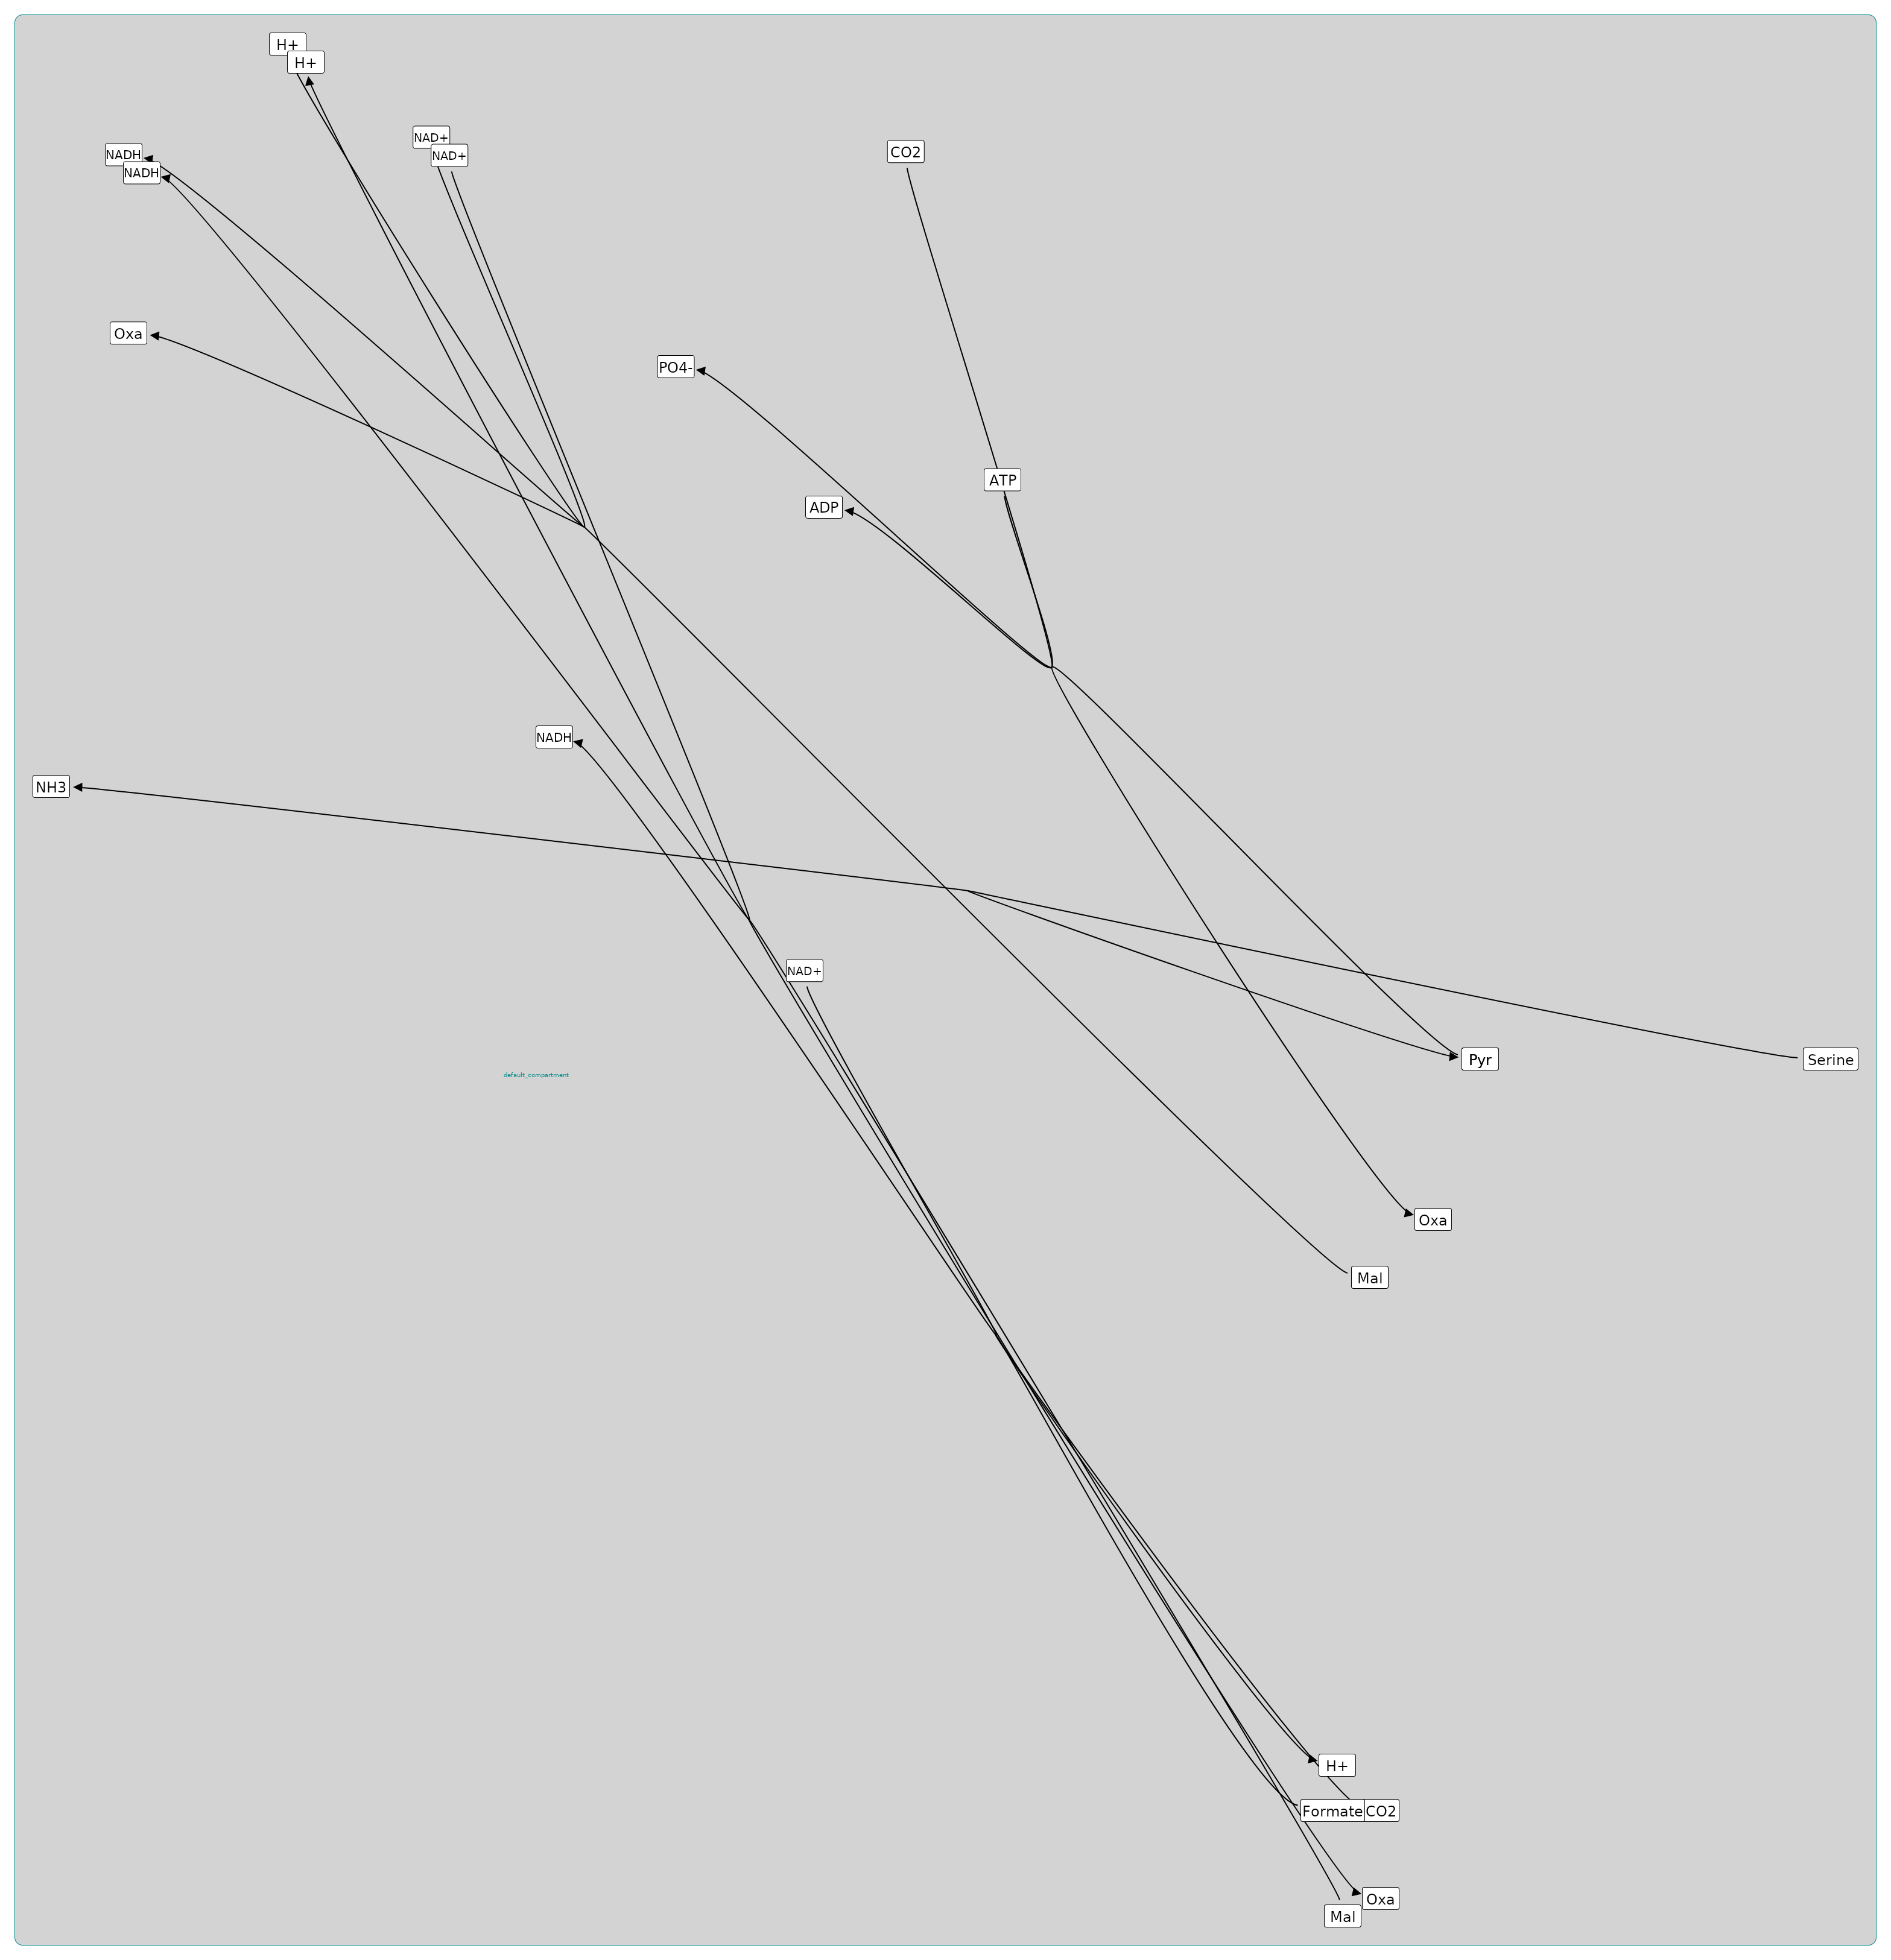

In [30]:
M0.draw()

In [31]:
M0.makeSpeciesGlyphsVisible(speciesToHide, visible=False)

0

In [32]:
M0.makeSpeciesGlyphsVisible([['Serine','R269']], visible=False)

0

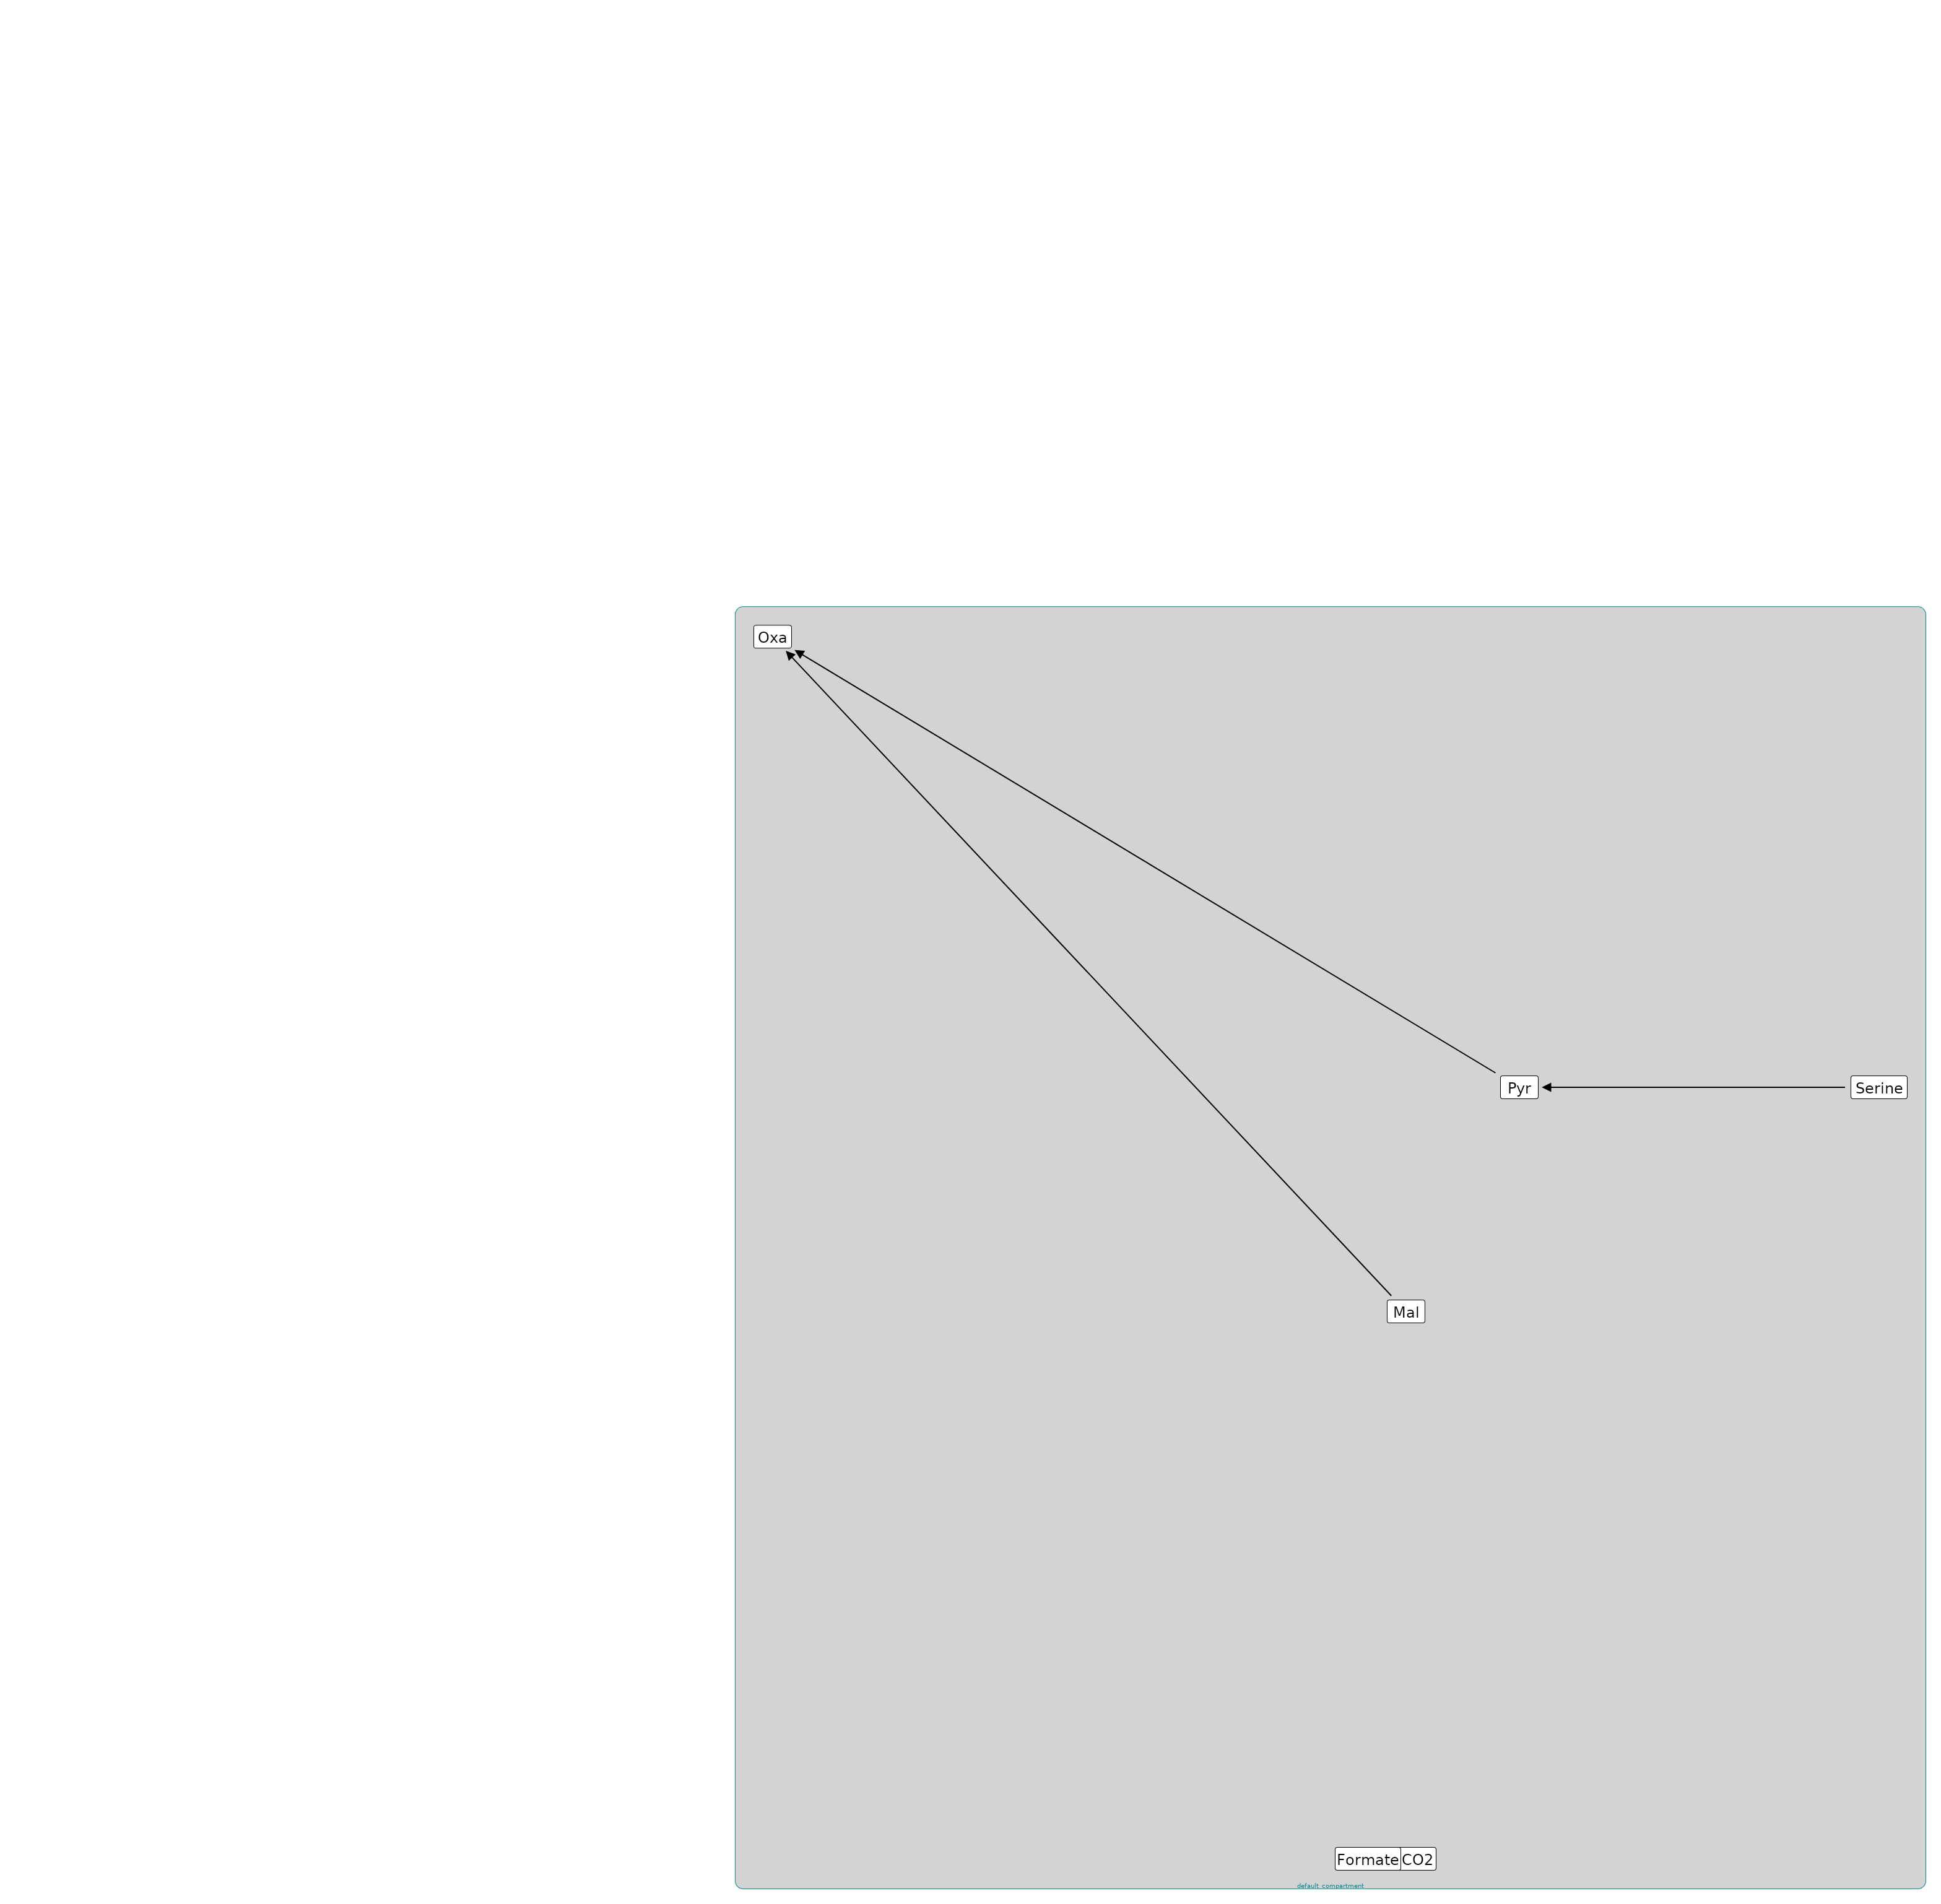

In [33]:
M0.draw()

In [34]:
# M1.autolayout(max_num_connected_edges=1)
# set_nodes = []
# speciesToHide = []

# for rxn_label, specs in specs_in_rxns.items():
#     corresponding_ID = label_to_ID_dict[rxn_label]
#     for spec in specs:
#         spec_react = spec + '_' + corresponding_ID
#         matching_keys = [key for key in cpd_coordinates_map_tran if key.startswith(spec_react)]
        
#         if matching_keys:
#             # Process each matching key, create aliases if multiple coordinates exist
#             for key_index, key in enumerate(matching_keys):
#                 if key_index > 0:  # For each additional match beyond the first, create an alias
#                     M1.createAliasReactionGlyph(rxn_label)
                
#                 # Get the reaction glyph index, ensuring we have the most recent one
#                 rxn_glyph_index = M1.getNumReactionGlyphs(rxn_label) - 1
#                 # Get species glyph index for placing coordinates
#                 specesglyphindex = M1.getSpeciesGlyphIndex(spec, rxn_label, reaction_glyph_index=rxn_glyph_index)
                
#                 coords = cpd_coordinates_map_tran[key]
#                 set_nodes.append(spec)
#                 M1.setX(spec, coords[0], graphical_object_index=specesglyphindex)
#                 M1.setY(spec, coords[1], graphical_object_index=specesglyphindex)
                
#                 print(f'{spec_react} in {rxn_label}/{corresponding_ID} has species glyph index {specesglyphindex} and coordinates {coords} from KEGG')
#         else:
#             # If no coordinates available, log to speciesToHide and move on
#             print(f'{spec_react} in {rxn_label}/{corresponding_ID} has no available coordinates from KEGG')
#             speciesToHide.append([spec, rxn_label])

## Hiding all species which were not assigned coordinates from KEGG.
The problem you can see we're running into now is that the model is not including the instances of some species which are in duplicated reactions (ie. they show up in two different spots on the map, but they are the exact same reaction) because it is overwriting them as there is no difference in species, reaction, or graphical object index. These are the green boxes with red writing in the image I shared with you in the email.

The other problem we have, and I don't have a good explanation for this, is that some species are initially being assigned coordinates in the drawing above, but then once we use the hide function, the coordinates seem to be removed, and they are being moved with autolayout it seems. You can see these in the highlighted image I shared with you in the email.

In [35]:
M1.makeSpeciesGlyphsVisible()

NameError: name 'M1' is not defined

In [ ]:
M1.makeSpeciesGlyphsVisible(speciesToHide, visible=False)

In [ ]:
M1.draw()

## IGNORE FROM HERE ON
## Colorbar

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

In [ ]:
r = te.loads('/workspaces/ECFERS/src/frenda_brenda/Files/SBML models/241022_prelim_M1.sbml')

In [ ]:
def get_color_from_gradient(value, min_val, max_val):
    # Normalize the value within the range
    norm = (value - min_val) / (max_val - min_val)
    # Use the color map 'coolwarm' from matplotlib
    cmap = plt.get_cmap('coolwarm')
    # Get the color in RGBA format
    rgba_color = cmap(norm)
    # Convert RGBA to HEX
    hex_color = mcolors.to_hex(rgba_color)
    return hex_color

In [ ]:
def colorByFlux(model, sbml, time, cmap='coolwarm'):
    sbml.reset()
    sbml.simulate(0,time)
    rates = sbml.getReactionRates()

    maxrate = rates.max()
    minrate = rates.min()

    reaction_flux_dict = {reaction_id: get_color_from_gradient(rate, minrate, maxrate) for reaction_id, rate in zip(np.array(sbml.getReactionIds()), rates)}

    for rid in reaction_flux_dict.keys():
        model.setLineColor(rid, reaction_flux_dict[rid])

    return model

In [ ]:
colorByFlux(M1, r, 1800).draw()

### Messing with curves

In [ ]:
M1.setCurveSegmentBasePoint1X('R10', 2764.0)
M1.setCurveSegmentBasePoint1Y('R10', 1220.0)

M1.setCurveSegmentBasePoint2X('R10', 2764.0)
M1.setCurveSegmentBasePoint2Y('R10', 1220.0)

M1.setLineColor('R10', 'green')

M1.draw()

In [ ]:
M1.getSpeciesReferenceIndexAssociatedWithSpecies("GA3P", "R10")

In [ ]:
M1.setSpeciesReferenceCurveSegmentStartPointX('R10', 2764.0, M1.getSpeciesReferenceIndexAssociatedWithSpecies())
M1.setSpeciesReferenceCurveSegmentStartPointY('R10', 943.0)

M1.setSpeciesReferenceCurveSegmentEndPointX('R10', 2399.0)
M1.setSpeciesReferenceCurveSegmentEndPointY('R10', 1220.0)

M1.setSpeciesReferenceCurveSegmentBasePoint1X('R10', 2764.0)
M1.setSpeciesReferenceCurveSegmentBasePoint1Y('R10', 1220.0)

M1.setSpeciesReferenceCurveSegmentBasePoint2X('R10', 2764.0)
M1.setSpeciesReferenceCurveSegmentBasePoint2Y('R10', 1220.0)

M1.draw()